### Pokazać różnicę metryk na zbiorze treningowym a testowym żeby analizować pod kątem przeuczenia / niedouczenia
### Nie robić gridsearcha po wszystkich parametrów, wybieramy jakiś w miare dobry a potem analizujemy na tej podstawie wpływ 3 parametrów
### Rysować drzewa ale z głową (nie całe sprawozdanie z drzewami), wybrać takie co pokazują jakieś zjawiska
### Można accuracy nie raportować w ogóle, lepiej macierz pomyłek
### Zadanie 7 tylko na zbiorze PCB

In [143]:
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import load_iris, load_wine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

## Wczytywanie zbiorów

In [2]:
glass = fetch_ucirepo(id=42)
glass.data.features.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [3]:
glass_dataset = pd.concat([glass.data.features, glass.data.targets], axis=1)
glass_dataset.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
with open("data/raw/polish_bankruptcy.pkl", "rb") as f:
    companies = pickle.load(f)

## Czyszczenie zbiorów

In [5]:
print("Null Value Counts in Glass Dataset:")
print("---------------------------------")
for column, count in glass_dataset.isnull().sum().items():
    print(f"{column:15} : {count}")

Null Value Counts in Glass Dataset:
---------------------------------
RI              : 0
Na              : 0
Mg              : 0
Al              : 0
Si              : 0
K               : 0
Ca              : 0
Ba              : 0
Fe              : 0
Type_of_glass   : 0


In [6]:
glass_dataset.duplicated().sum()

np.int64(1)

In [7]:
glass_dataset = glass_dataset.drop_duplicates()

In [ ]:
def clip_outliers_column_by_class(df, column, class_column, class1, class2):
    df_copy = df.copy(deep=True)
    class1_data = df_copy[df_copy[class_column] == class1]
    class2_data = df_copy[df_copy[class_column] == class2]

    q1_1 = class1_data[column].quantile(0.25)
    q3_1 = class1_data[column].quantile(0.75)
    iqr_1 = q3_1 - q1_1
    lower_bound_1 = q1_1 - 1.5 * iqr_1
    upper_bound_1 = q3_1 + 1.5 * iqr_1

    q1_2 = class2_data[column].quantile(0.25)
    q3_2 = class2_data[column].quantile(0.75)
    iqr_2 = q3_2 - q1_2
    lower_bound_2 = q1_2 - 1.5 * iqr_2
    upper_bound_2 = q3_2 + 1.5 * iqr_2

    mask_class1 = (df_copy[class_column] == class1)
    df_copy.loc[mask_class1 & (df_copy[column] < lower_bound_1), column] = lower_bound_1
    df_copy.loc[mask_class1 & (df_copy[column] > upper_bound_1), column] = upper_bound_1

    mask_class2 = (df_copy[class_column] == class2)
    df_copy.loc[mask_class2 & (df_copy[column] < lower_bound_2), column] = lower_bound_2
    df_copy.loc[mask_class2 & (df_copy[column] > upper_bound_2), column] = upper_bound_2

    return df_copy

def clip_outliers_by_class(df, columns, class_column, class1, class2):
    data = df.copy(deep=True)
    for col in columns:
        print(f"\nProcessing column: {col}")
        print(f"Initial shape: {data.shape}")
        print(f"Initial variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

        data = clip_outliers_column_by_class(data, col, class_column, class1, class2)

        print(f"\nAfter clipping outliers:")
        print(f"Shape remains: {data.shape}")
        print(f"New variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

    return data

In [12]:
companies.duplicated().sum()

np.int64(401)

In [13]:
companies = companies.drop_duplicates()

### Podział na zbiory treningowy/testowy

In [32]:
X_glass, y_glass = glass_dataset.iloc[:, :-1], glass_dataset.iloc[:, -1]
X_companies, y_companies = companies.iloc[:, :-1], companies.iloc[:, -1]
X_train_glass, X_test_glass, y_train_glass, y_test_glass = train_test_split(glass_dataset.iloc[:, :-1], glass_dataset.iloc[:, -1], test_size=0.2, stratify=glass_dataset.iloc[:, -1])
X_train_companies, X_test_companies, y_train_companies, y_test_companies = train_test_split(companies.iloc[:, :-1], companies.iloc[:, -1], test_size=0.2, stratify=companies.iloc[:, -1])
print(X_train_glass.shape)
print(X_test_glass.shape)
print(X_train_companies.shape)
print(X_test_companies.shape)

(170, 9)
(43, 9)
(34403, 65)
(8601, 65)


### Uruchomienie drzewa decyzyjnego dla domyślnych parametrów (oraz bez skalowanie i PCA)

a) glass

In [64]:
model = DecisionTreeClassifier()
model.fit(X_train_glass, y_train_glass)

DecisionTreeClassifier()

In [65]:
print("Głębokość drzewa:", model.get_depth())

Głębokość drzewa: 11



Test results:

Classification Report for Glass dataset:
              precision    recall  f1-score   support

           1       0.71      0.71      0.71        14
           2       0.65      0.73      0.69        15
           3       0.25      0.33      0.29         3
           5       1.00      0.67      0.80         3
           6       1.00      0.50      0.67         2
           7       1.00      0.83      0.91         6

    accuracy                           0.70        43
   macro avg       0.77      0.63      0.68        43
weighted avg       0.73      0.70      0.71        43



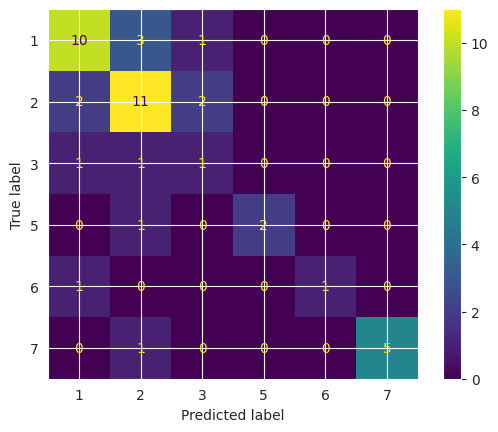

In [22]:
predictions = model.predict(X_test_glass)
print("\nTest results:")
print("\nClassification Report for Glass dataset:")
print(classification_report(y_test_glass, predictions))

cm = confusion_matrix(y_test_glass, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

b) companies

In [62]:
model = DecisionTreeClassifier()
model.fit(X_train_companies, y_train_companies)

DecisionTreeClassifier()


Test results:

Classification Report for Polish Bankruptcy dataset:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8184
           1       0.55      0.55      0.55       417

    accuracy                           0.96      8601
   macro avg       0.76      0.76      0.76      8601
weighted avg       0.96      0.96      0.96      8601



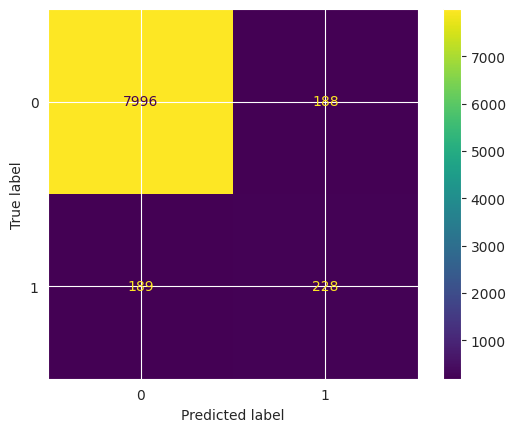

In [24]:
predictions = model.predict(X_test_companies)
print("\nTest results:")
print("\nClassification Report for Polish Bankruptcy dataset:")
print(classification_report(y_test_companies, predictions))

cm = confusion_matrix(y_test_companies, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Wstępne dostrojenie drzewa ze względu na parametr *max_depth*

a) glass

In [105]:
model = DecisionTreeClassifier()
model.fit(X_glass, y_glass)

DecisionTreeClassifier()

In [106]:
print("Głębokość drzewa:", model.get_depth())
print("Params:", model.get_params())

Głębokość drzewa: 12
Params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


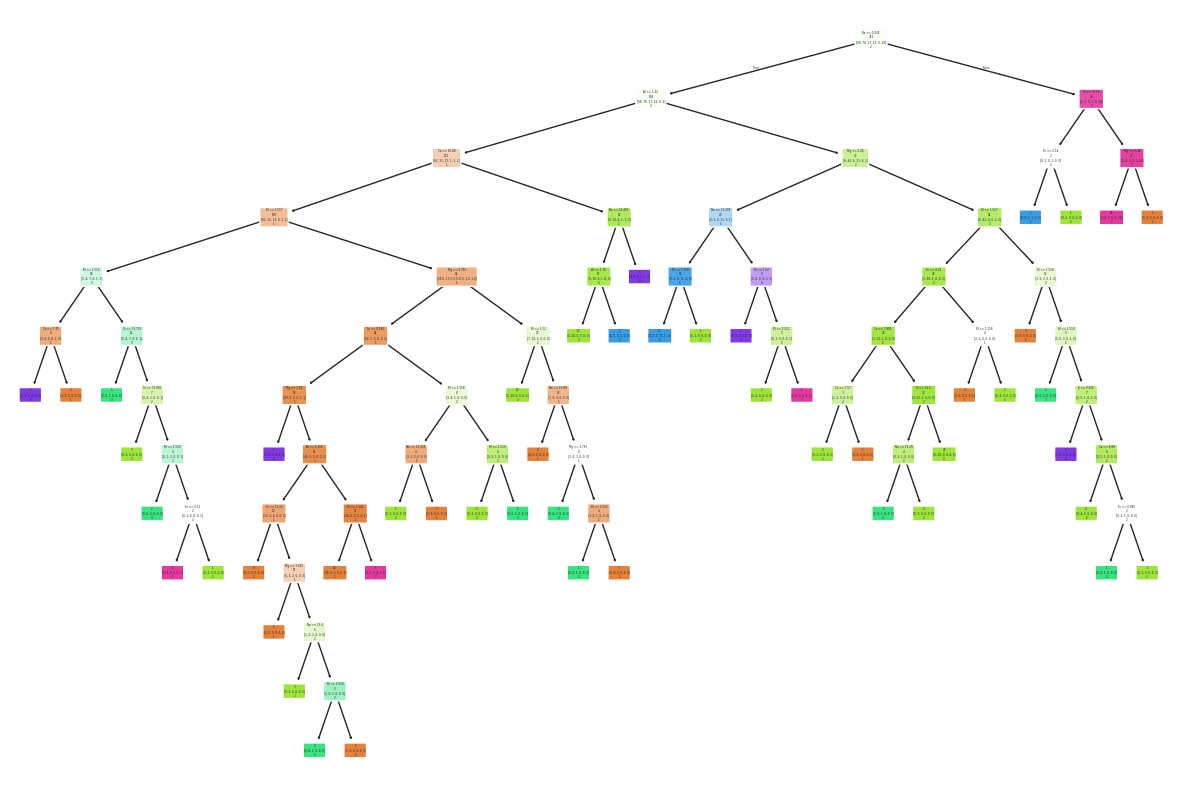

In [108]:
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=X_glass.columns, class_names=[str(y) for y in y_glass.unique()], rounded=True,  fontsize=2, impurity=False, label='none')
plt.show()

In [76]:
depth_glass = [None, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
scores_glass = []
for d in depth_glass:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=d)
    f1_scores = cross_val_score(model, X_glass, y_glass, cv=cv, scoring="f1_macro")
    scores_glass.append(f1_scores)

b) Companies

In [100]:
model = DecisionTreeClassifier()
model.fit(X_companies, y_companies)

DecisionTreeClassifier()

In [101]:
print("Głębokość drzewa:", model.get_depth())

Głębokość drzewa: 36


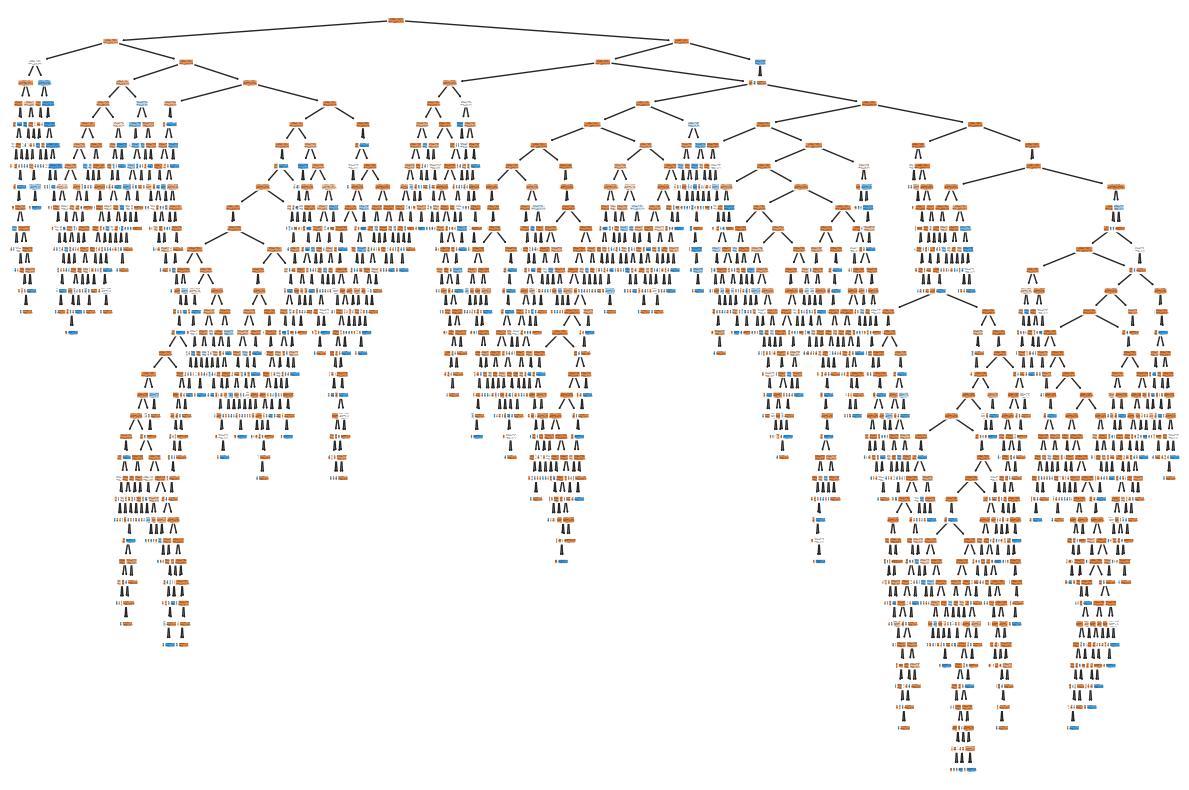

In [103]:
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=X_companies.columns, class_names=[str(y) for y in y_companies.unique()], rounded=True, impurity=False, label='none')
plt.show()

In [68]:
depth = [None, 30, 25, 15, 10, 5]
scores = []

for d in depth:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=d)
    f1_scores = cross_val_score(model, X_companies, y_companies, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

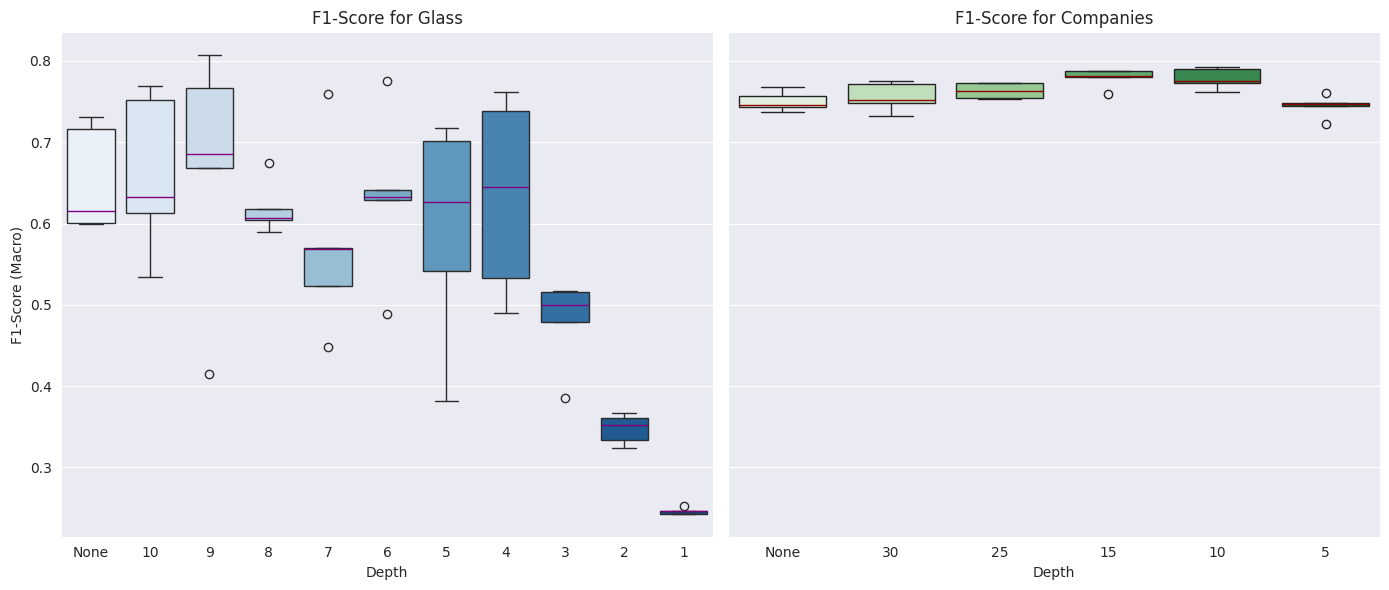

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(ax=axes[0], data=scores_glass, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
axes[0].set_xticks(range(len(depth_glass)))
axes[0].set_xticklabels([str(d) for d in depth_glass])
axes[0].set_title("F1-Score for Glass")
axes[0].set_xlabel("Depth")
axes[0].set_ylabel("F1-Score (Macro)")

sns.boxplot(ax=axes[1], data=scores, palette="Greens", medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})
axes[1].set_xticks(range(len(depth)))
axes[1].set_xticklabels([str(d) for d in depth])
axes[1].set_title("F1-Score for Companies")
axes[1].set_xlabel("Depth")

plt.tight_layout()
plt.show()

Na tej podstawie do dalszej analizy zbioru Companies wymieram parametr max_depth = 15, a dla zbioru Glass max_depth = 9

### Analiza wpływu hiperparametrów na wyniki modelu


#### a) min_samples_leaf

In [113]:
min_samples_leaf = [1, 5, 10, 15, 20]

In [124]:
scores_glass_msl = []
for msl in min_samples_leaf:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=9, min_samples_leaf=msl)
    f1_scores = cross_val_score(model, X_glass, y_glass, cv=cv, scoring="f1_macro")
    scores_glass_msl.append(f1_scores)

In [126]:
scores_companies_msl = []
for msl in min_samples_leaf:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=msl)
    f1_scores = cross_val_score(model, X_companies, y_companies, cv=cv, scoring="f1_macro")
    scores_companies_msl.append(f1_scores)

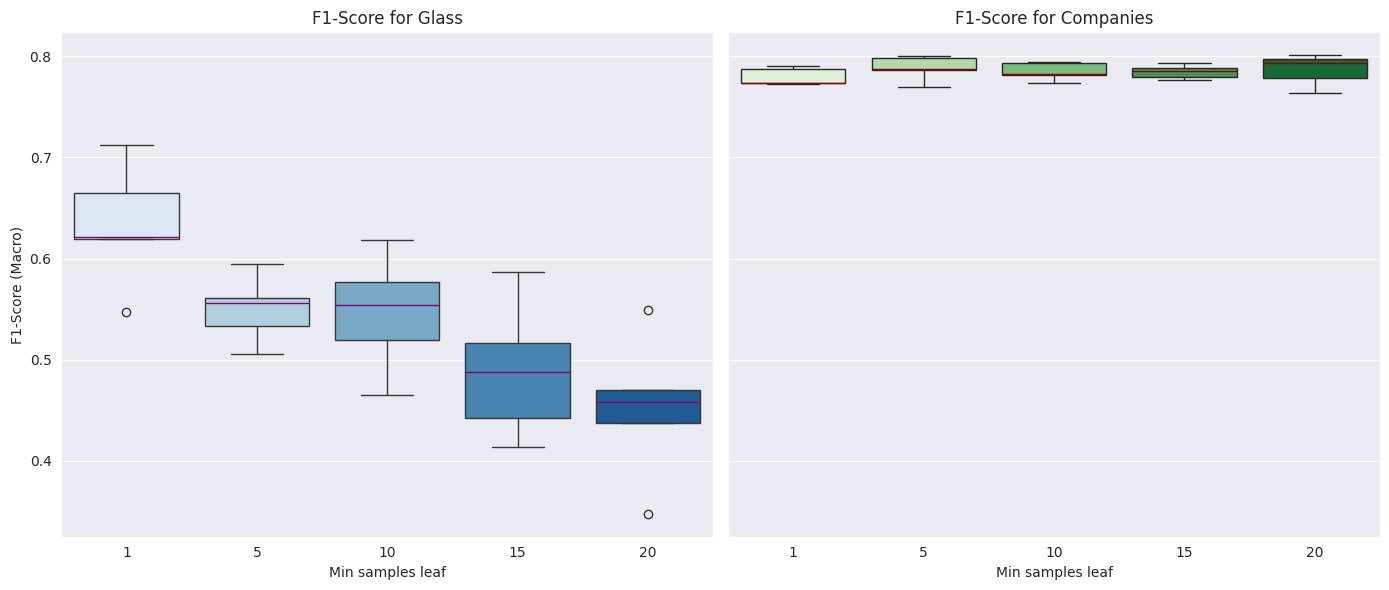

In [127]:
_, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(ax=axes[0], data=scores_glass_msl, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
axes[0].set_xticks(range(len(min_samples_leaf)))
axes[0].set_xticklabels([str(d) for d in min_samples_leaf])
axes[0].set_title("F1-Score for Glass")
axes[0].set_xlabel("Min samples leaf")
axes[0].set_ylabel("F1-Score (Macro)")

sns.boxplot(ax=axes[1], data=scores_companies_msl, palette="Greens", medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})
axes[1].set_xticks(range(len(min_samples_leaf)))
axes[1].set_xticklabels([str(d) for d in min_samples_leaf])
axes[1].set_title("F1-Score for Companies")
axes[1].set_xlabel("Min samples leaf")

plt.tight_layout()
plt.show()

Widać, że dla zbioru Glass , przy większych ilościach próbek na liść otrzymujemy słabsze wyniki. Wynika to z tego, że zbiór jest stosunkowo mały i przy większej ilości próbek na każdym liściu model słabiej dopasowuje się do problemu i mamy underfitting.

Odwrotnie jest w przypadku zbioru Companies, który jest znacznie większy. Tutaj przy większej ilości próbek na każdy liść uzyskujemy lepszą regularyzację drzewa przez co polepszają się jego zdolności generalizacji.

In [131]:
def compare_models(model_1, model_2, X_train, y_train, X_test, y_test):
    model_1.fit(X_train, y_train)
    pred_train_1 = model_1.predict(X_train)
    f1_train_1 = f1_score(pred_train_1, y_train, average="macro")
    pred_test_1 = model_1.predict(X_test)
    f1_test_1 = f1_score(pred_test_1, y_test, average="macro")
    model_2.fit(X_train, y_train)
    pred_train_2 = model_2.predict(X_train)
    f1_train_2 = f1_score(pred_train_2, y_train, average="macro")
    pred_test_2 = model_2.predict(X_test)
    f1_test_2 = f1_score(pred_test_2, y_test, average="macro")
    return f1_train_1, f1_test_1, f1_train_2, f1_test_2

In [135]:
model_1 = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
model_2 = DecisionTreeClassifier(max_depth=9, min_samples_leaf=20)
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_glass, y_train_glass, X_test_glass, y_test_glass)
f1_df = pd.DataFrame({
    "Min samples leaf": ["1", "20"],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print("Glass Dataset")
print(f1_df.to_string(index=False))

Glass Dataset
Min samples leaf  F1 Score (Train)  F1 Score (Test)
               1          0.975731         0.618541
              20          0.491927         0.499022


In [138]:
print("Companies Dataset")
model_1 = DecisionTreeClassifier(max_depth=15, min_samples_leaf=1)
model_2 = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_companies, y_train_companies, X_test_companies, y_test_companies)
f1_df = pd.DataFrame({
    "Min samples leaf": ["1", "20"],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print(f1_df.to_string(index=False))

Companies Dataset
Min samples leaf  F1 Score (Train)  F1 Score (Test)
               1          0.941044         0.776962
              20          0.830793         0.794861


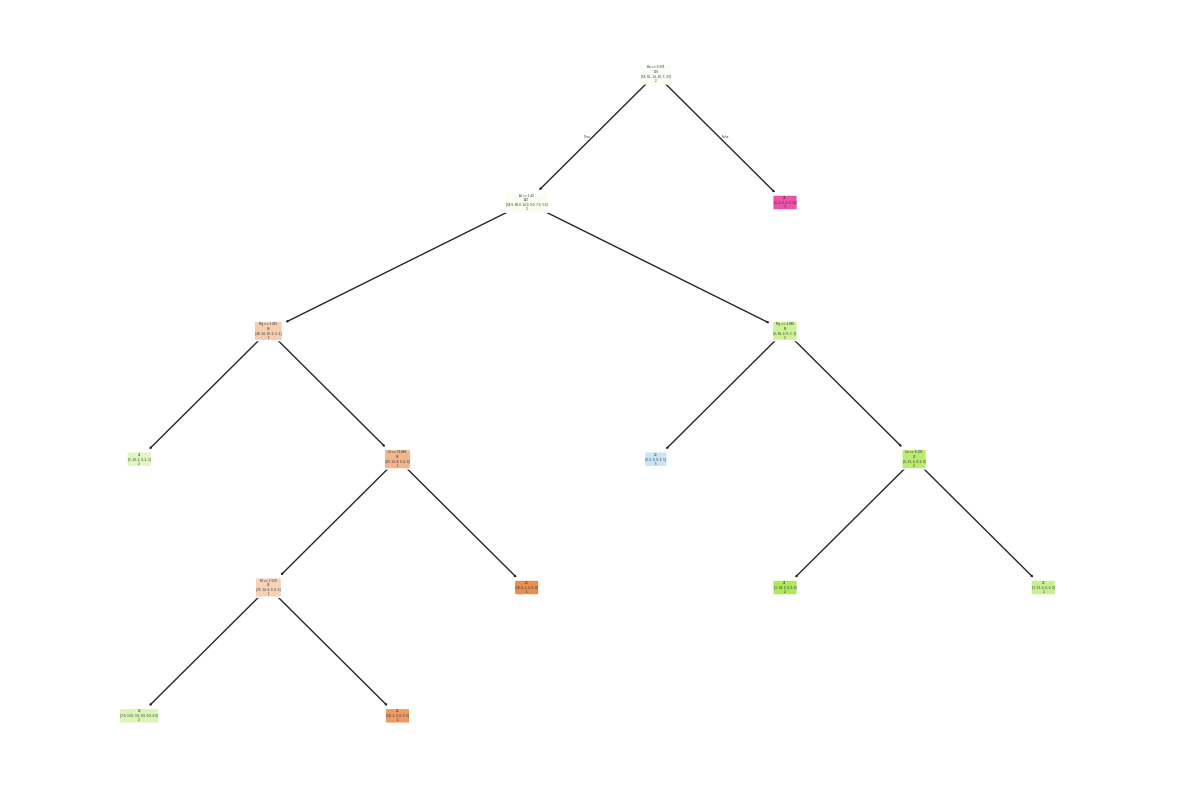

In [137]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_glass.columns, class_names=[str(y) for y in y_glass.unique()], rounded=True,  fontsize=2, impurity=False, label='none')
plt.show()

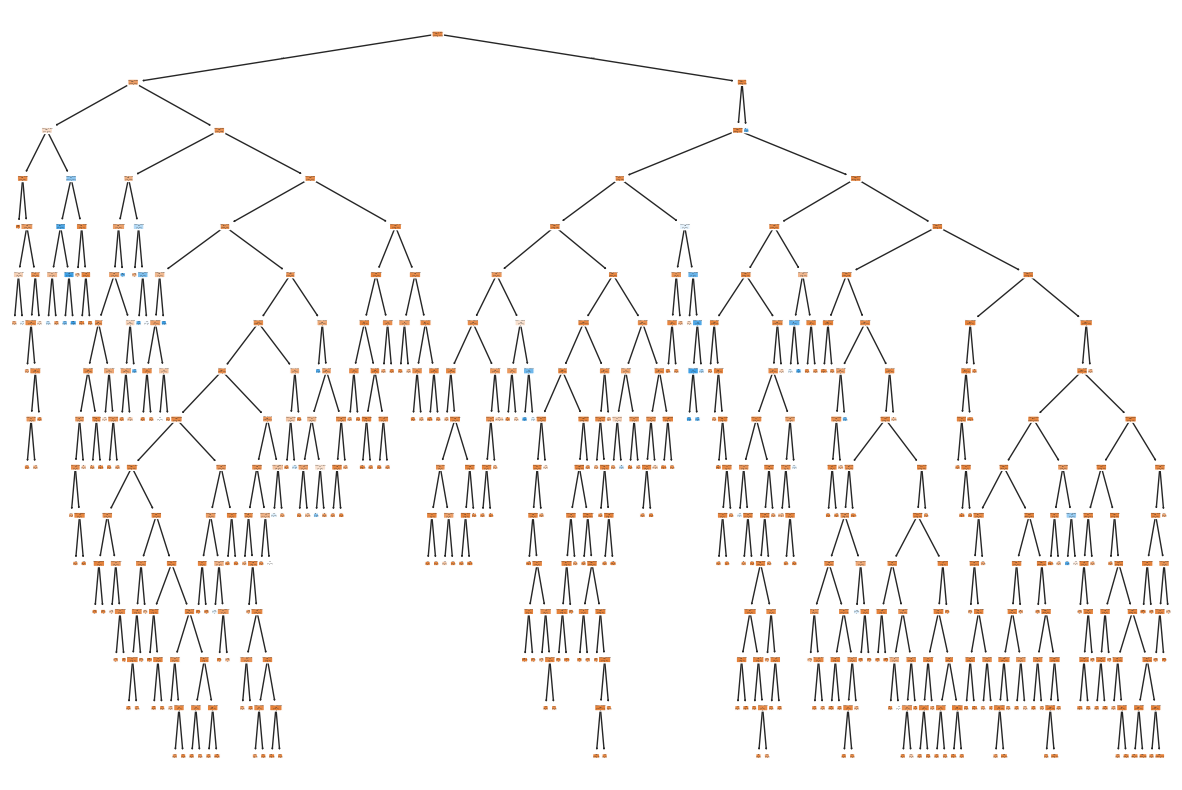

In [134]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_companies.columns, class_names=[str(y) for y in y_companies.unique()], rounded=True, impurity=False, label='none')
plt.show()

#### b) cpp_alpha

In [ ]:
ccp_alpha = [1, 5, 10, 15, 20]

In [162]:
model = DecisionTreeClassifier(max_depth=9)
path = model.cost_complexity_pruning_path(X_glass, y_glass)
ccp_alphas_glass = path.ccp_alphas
ccp_alphas_unique = np.unique(ccp_alphas_glass)
alpha_groups = np.array_split(ccp_alphas_unique, 4)
sampled_alphas_glass = [group[len(group) // 2] for group in alpha_groups]
sampled_alphas_glass.insert(0, 0.0)
sampled_alphas_glass.append(ccp_alphas_unique.max())
print("Liczba unikalnych wartości ccp_alpha:", len(ccp_alphas_unique))
print("Zakres ccp_alpha:", ccp_alphas_unique.min(), "-", ccp_alphas_unique.max())
print("ccp_alpha do przetestowania:", sampled_alphas_glass)

Liczba unikalnych wartości ccp_alpha: 29
Zakres ccp_alpha: 0.0 - 0.1221075800789021
ccp_alpha do przetestowania: [0.0, np.float64(0.006259780907668231), np.float64(0.008215962441314553), np.float64(0.01248958202171737), np.float64(0.040301810865191134), np.float64(0.1221075800789021)]


In [163]:
model = DecisionTreeClassifier(max_depth=15)
path = model.cost_complexity_pruning_path(X_companies, y_companies)
ccp_alphas_companies = path.ccp_alphas
ccp_alphas_unique = np.unique(ccp_alphas_companies)
alpha_groups = np.array_split(ccp_alphas_unique, 4)
sampled_alphas_companies = [group[len(group) // 2] for group in alpha_groups]
sampled_alphas_companies.insert(0, 0.0)
sampled_alphas_companies.append(ccp_alphas_unique.max())
print("Liczba unikalnych wartości ccp_alpha:", len(ccp_alphas_unique))
print("Zakres ccp_alpha:", ccp_alphas_unique.min(), "-", ccp_alphas_unique.max())
print("ccp_alpha do przetestowania:", sampled_alphas_companies)

Liczba unikalnych wartości ccp_alpha: 248
Zakres ccp_alpha: 0.0 - 0.006391834793196258
ccp_alpha do przetestowania: [0.0, np.float64(2.285952114821011e-05), np.float64(4.464700958050413e-05), np.float64(7.49190350157702e-05), np.float64(0.00016543432164584866), np.float64(0.006391834793196258)]


In [164]:
scores_glass_ccp = []
for ccp in sampled_alphas_glass:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=9, ccp_alpha=ccp)
    f1_scores = cross_val_score(model, X_glass, y_glass, cv=cv, scoring="f1_macro")
    scores_glass_ccp.append(f1_scores)

In [171]:
scores_companies_ccp = []

for ccp in sampled_alphas_companies:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=15, ccp_alpha=ccp)
    f1_scores = cross_val_score(model, X_companies, y_companies, cv=cv, scoring="f1_macro")
    scores_companies_ccp.append(f1_scores)

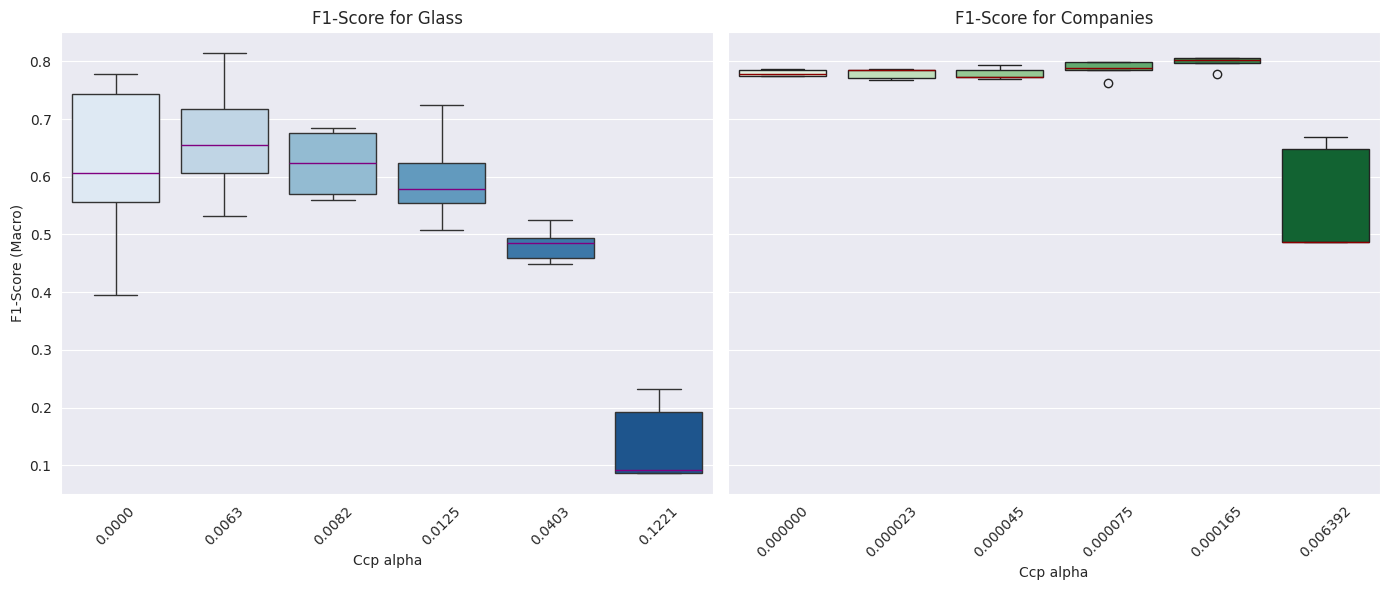

In [178]:
_, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(ax=axes[0], data=scores_glass_ccp, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
axes[0].set_xticks(range(len(sampled_alphas_glass)))
axes[0].set_xticklabels([f"{d:.4f}" for d in sampled_alphas_glass], rotation=45)
axes[0].set_title("F1-Score for Glass")
axes[0].set_xlabel("Ccp alpha")
axes[0].set_ylabel("F1-Score (Macro)")

sns.boxplot(ax=axes[1], data=scores_companies_ccp, palette="Greens",
            medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})
axes[1].set_xticks(range(len(sampled_alphas_companies)))
axes[1].set_xticklabels([f"{d:.6f}" for d in sampled_alphas_companies], rotation=45)
axes[1].set_title("F1-Score for Companies")
axes[1].set_xlabel("Ccp alpha")

plt.tight_layout()
plt.show()

W przypadku zbioru Glass delikatny prunning powoduje polepszenie zdolności generalizacji modelu, natomiast coraz większy powoduje znaczne jego pogorszenie. Spowodowane jest to tym, że zbiór danych jest stosunkowo mały, więc zbyt mocne przycinanie drzewa znacznie ogranicza jego mozliwości.

Dla zbioru Companies stopniowy prunning również polepsza wyniki. Tutaj możliwy jest intensywniejszy prunning, ze względu na rozmiary i złożoność danych. Również tutaj dla zbyt dużego przycinania zdolności modelu znacznie spadają.

In [189]:
model_1 = DecisionTreeClassifier(max_depth=9, ccp_alpha=sampled_alphas_glass[1])
model_2 = DecisionTreeClassifier(max_depth=9, ccp_alpha=sampled_alphas_glass[-2])
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_glass, y_train_glass, X_test_glass, y_test_glass)
f1_df = pd.DataFrame({
    "Ccp alpha": [sampled_alphas_companies[1], sampled_alphas_companies[-2]],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print("Glass Dataset")
print(f1_df.to_string(index=False))

Glass Dataset
 Ccp alpha  F1 Score (Train)  F1 Score (Test)
  0.000023          0.970032         0.554291
  0.000165          0.510918         0.548677


In [192]:
print("Companies Dataset")
model_1 = DecisionTreeClassifier(max_depth=15, ccp_alpha=sampled_alphas_companies[1])
model_2 = DecisionTreeClassifier(max_depth=15, ccp_alpha=sampled_alphas_companies[-2])
f1_train_1, f1_test_1, f1_train_2, f1_test_2 = compare_models(model_1, model_2, X_train_companies, y_train_companies, X_test_companies, y_test_companies)
f1_df = pd.DataFrame({
    "Ccp alpha": [sampled_alphas_companies[1], sampled_alphas_companies[-2]],
    "F1 Score (Train)": [f1_train_1, f1_train_2],
    "F1 Score (Test)": [f1_test_1, f1_test_2]
})

print(f1_df.to_string(index=False))

Companies Dataset
 Ccp alpha  F1 Score (Train)  F1 Score (Test)
  0.000023          0.940661         0.779227
  0.000165          0.827620         0.795294


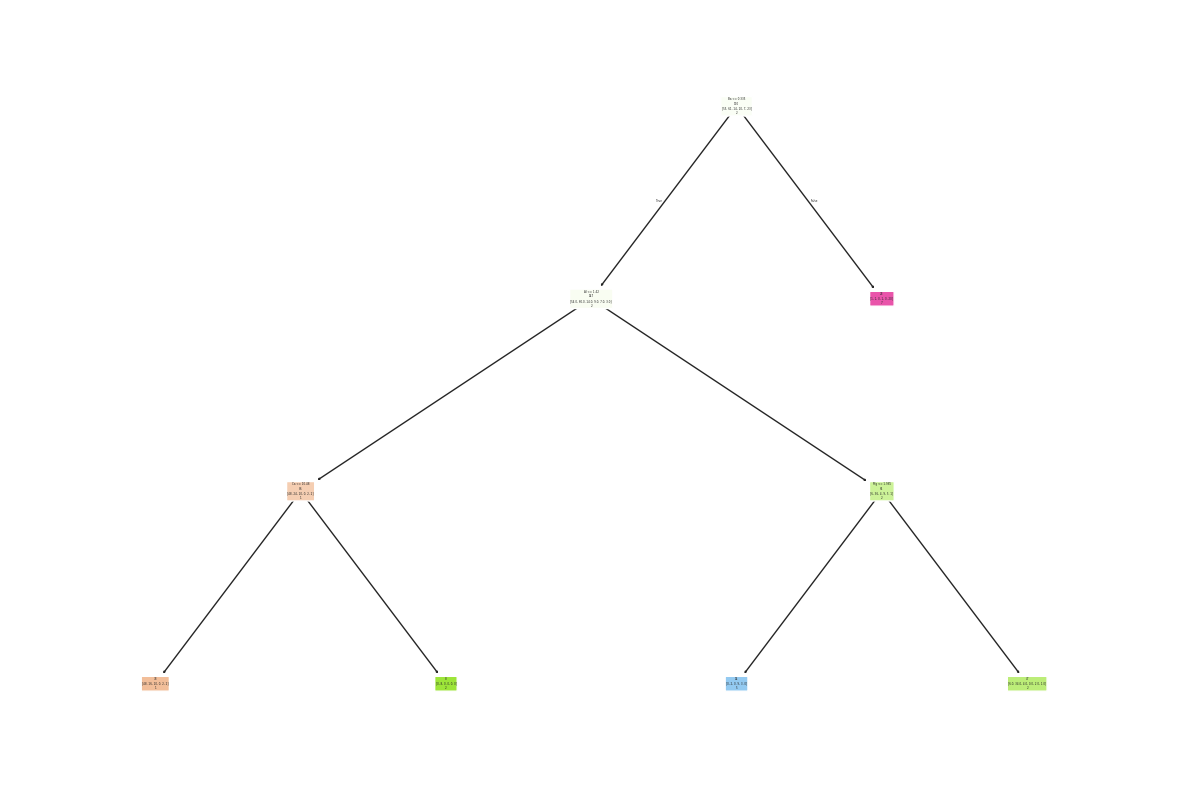

In [190]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_glass.columns, class_names=[str(y) for y in y_glass.unique()], rounded=True,  fontsize=2, impurity=False, label='none')
plt.show()

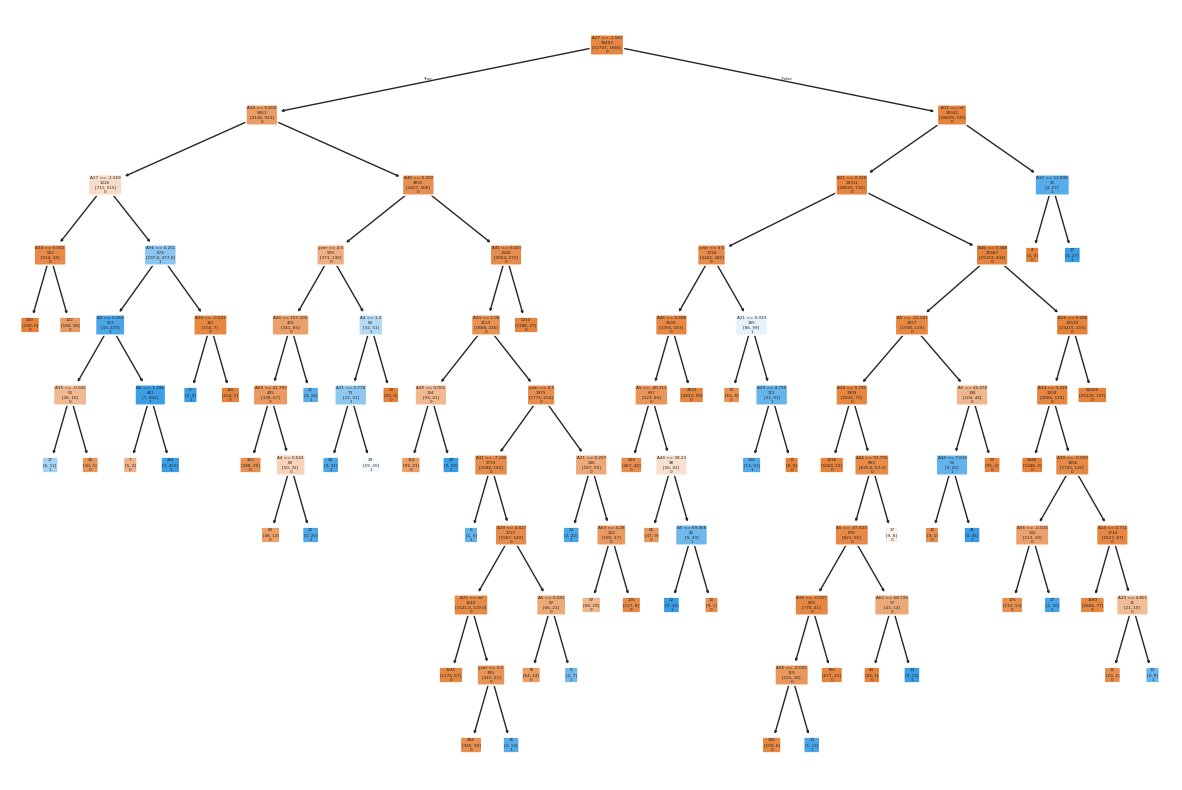

In [195]:
plt.figure(figsize=(15, 10))
plot_tree(model_2, filled=True, feature_names=X_companies.columns, class_names=[str(y) for y in y_companies.unique()], rounded=True, impurity=False, label='none', fontsize=3)
plt.show()

#### c) criterion

In [196]:
criterion = ["gini", "entropy", "log_loss"]

In [197]:
scores_glass_criterion = []
for crit in criterion:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=9, criterion=crit)
    f1_scores = cross_val_score(model, X_glass, y_glass, cv=cv, scoring="f1_macro")
    scores_glass_criterion.append(f1_scores)

In [198]:
scores_companies_criterion = []
for crit in criterion:
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=15, criterion=crit)
    f1_scores = cross_val_score(model, X_companies, y_companies, cv=cv, scoring="f1_macro")
    scores_companies_criterion.append(f1_scores)

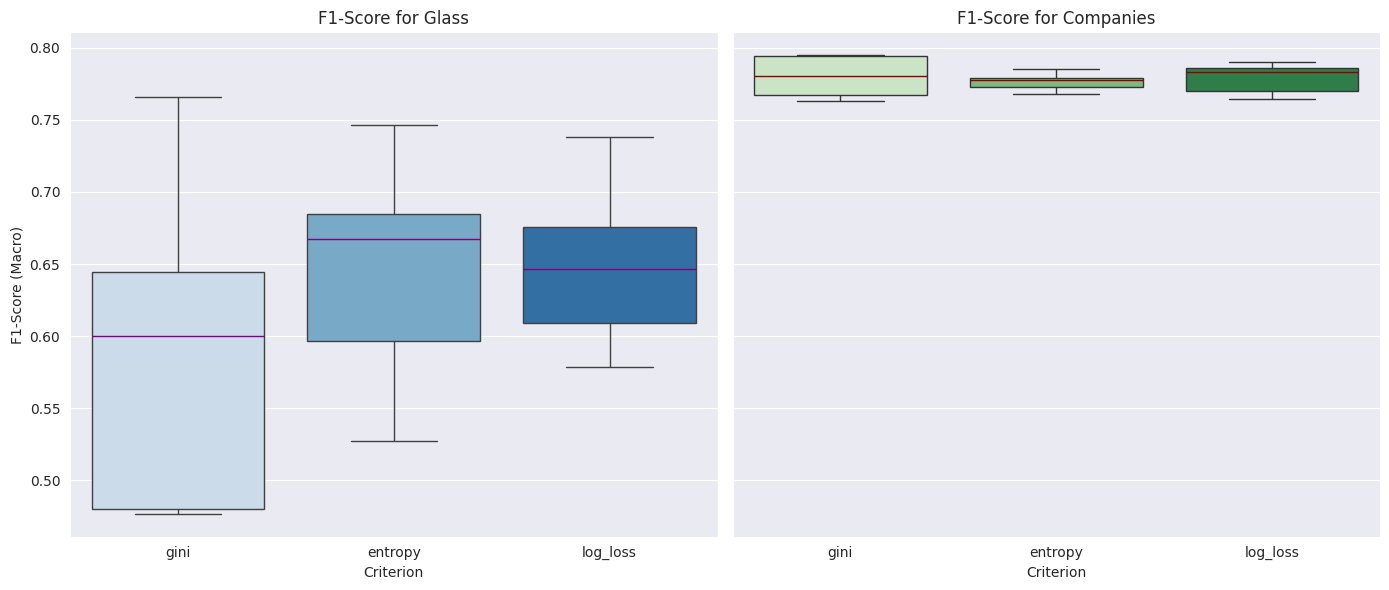

In [200]:
_, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(ax=axes[0], data=scores_glass_criterion, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
axes[0].set_xticks(range(len(criterion)))
axes[0].set_xticklabels([d for d in criterion])
axes[0].set_title("F1-Score for Glass")
axes[0].set_xlabel("Criterion")
axes[0].set_ylabel("F1-Score (Macro)")

sns.boxplot(ax=axes[1], data=scores_companies_criterion, palette="Greens", medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})
axes[1].set_xticks(range(len(criterion)))
axes[1].set_xticklabels([d for d in criterion])
axes[1].set_title("F1-Score for Companies")
axes[1].set_xlabel("Criterion")

plt.tight_layout()
plt.show()

### Różnica między zwykłą walidacją krzyżową a stratyfikowaną

In [201]:
cv = KFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=9)
cv_scores_glass = cross_val_score(model, X_glass, y_glass, cv=cv, scoring="f1_macro")
strat_cv = StratifiedKFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=9)
strat_cv_scores_glass = cross_val_score(model, X_glass, y_glass, cv=strat_cv, scoring="f1_macro")

In [202]:
cv = KFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=15)
cv_scores_companies = cross_val_score(model, X_companies, y_companies, cv=cv, scoring="f1_macro")
strat_cv = StratifiedKFold(n_splits=5, shuffle=True)
model = DecisionTreeClassifier(max_depth=15)
strat_cv_scores_companies = cross_val_score(model, X_companies, y_companies, cv=strat_cv, scoring="f1_macro")

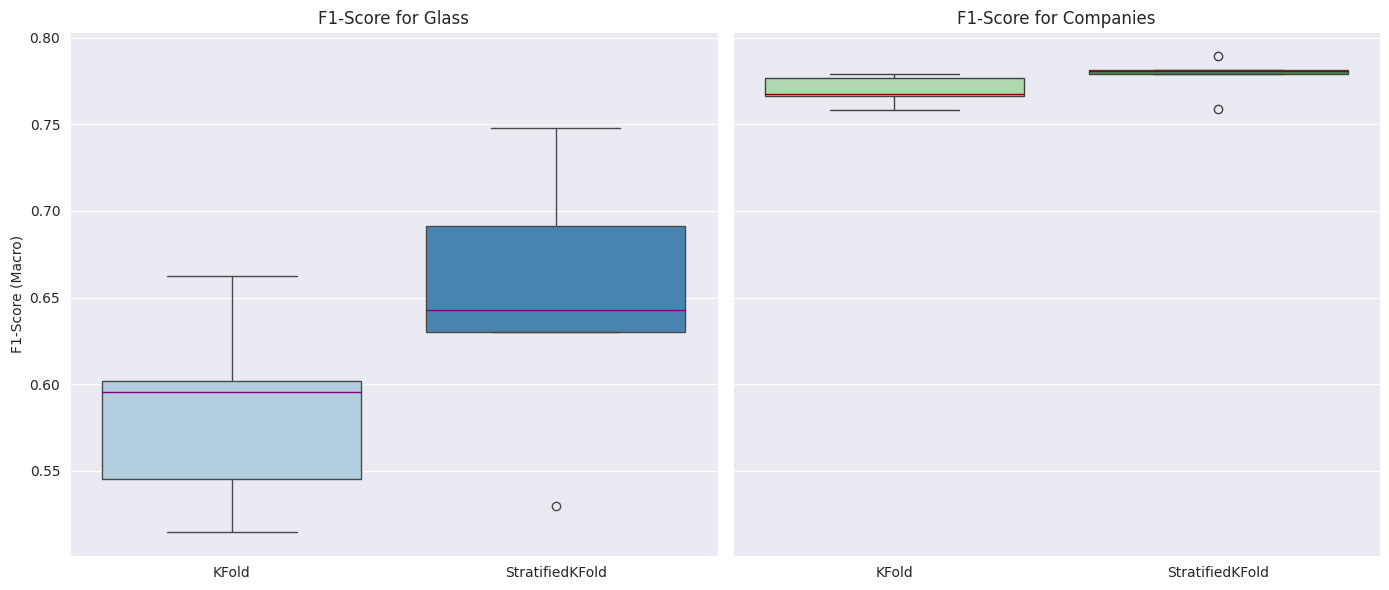

In [203]:
_, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(ax=axes[0], data=[cv_scores_glass, strat_cv_scores_glass], palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
axes[0].set_xticks(range(2))
axes[0].set_xticklabels(["KFold", "StratifiedKFold"])
axes[0].set_title("F1-Score for Glass")
axes[0].set_ylabel("F1-Score (Macro)")

sns.boxplot(ax=axes[1], data=[cv_scores_companies, strat_cv_scores_companies], palette="Greens", medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(["KFold", "StratifiedKFold"])
axes[1].set_title("F1-Score for Companies")

plt.tight_layout()
plt.show()

Dla obydwu zbiorów lepsze i stabilniejsze wyniki dała walidacja krzyżowa stratyfikowana. Dzięki zachowaniu dystrybucji klas pomiędzy różnymi foldami możemy wnioskować jak prawdopodobnie będzie zachowywał się model dla całego zbioru danych oraz ograniczamy ryzyko, w którym powstałby fold gdzie do treningu wykorzystane są próbki z tylko jednej klasy a do walidacji próbki z drugiej co znacznie zaniżyłoby wyniki.

### Analiza wyników w zależności od zastosowania parametru *class_weight* - zbiór Companies

In [210]:
class_weight = [None, {0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}, "balanced"]

In [211]:
scores_companies_weight = []
for weight in class_weight:
    strat_cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = DecisionTreeClassifier(max_depth=15, class_weight=weight)
    f1_scores = cross_val_score(model, X_companies, y_companies, cv=strat_cv, scoring="f1_macro")
    scores_companies_weight.append(f1_scores)

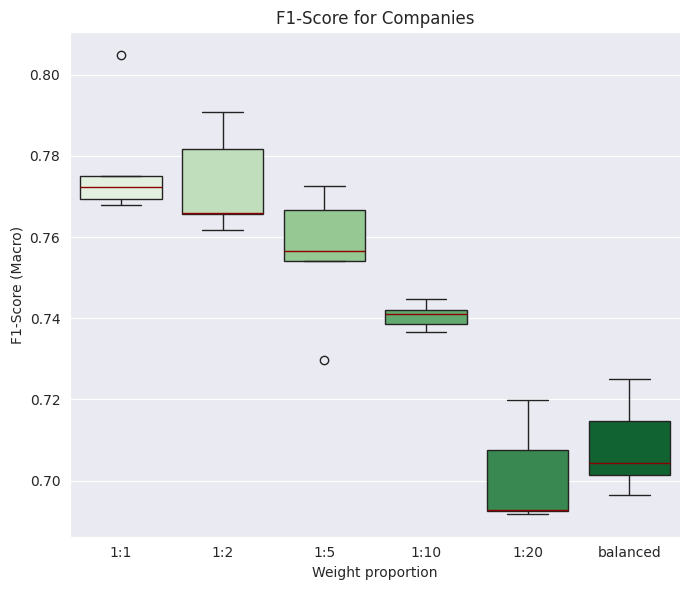

In [213]:
plt.figure(figsize=(7, 6))

sns.boxplot(data=scores_companies_weight, palette="Greens", medianprops={'color': 'darkred', 'ls': '-', 'lw': 1})

plt.xticks(range(len(class_weight)), ["1:1", "1:2", "1:5", "1:10", "1:20", "balanced"])
plt.title("F1-Score for Companies")
plt.xlabel("Weight proportion")
plt.ylabel("F1-Score (Macro)")
plt.tight_layout()
plt.show()

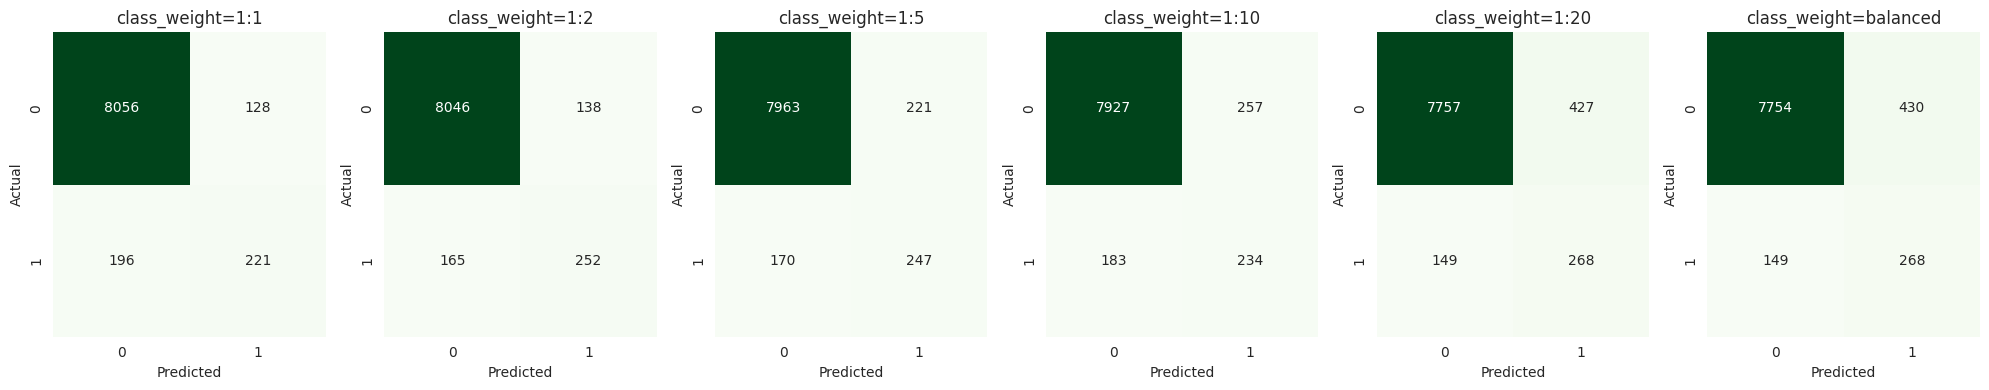

In [230]:
labels = ["1:1", "1:2", "1:5", "1:10", "1:20", "balanced"]

fig, axes = plt.subplots(1, len(class_weight), figsize=(20, 4))
reports = []
for i, weight in enumerate(class_weight):
    model = DecisionTreeClassifier(max_depth=15, class_weight=weight)
    model.fit(X_train_companies, y_train_companies)
    y_pred = model.predict(X_test_companies)

    report_dict = classification_report(y_test_companies, y_pred, output_dict=True)
    df = pd.DataFrame(report_dict).transpose().round(2)
    df = df.drop("accuracy", errors="ignore")
    df = df[['precision', 'recall', 'f1-score', 'support']]
    reports.append((labels[i], df))

    cm = confusion_matrix(y_test_companies, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[i],
        xticklabels=np.unique(y_companies), yticklabels=np.unique(y_companies)
    )
    axes[i].set_title(f'class_weight={labels[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

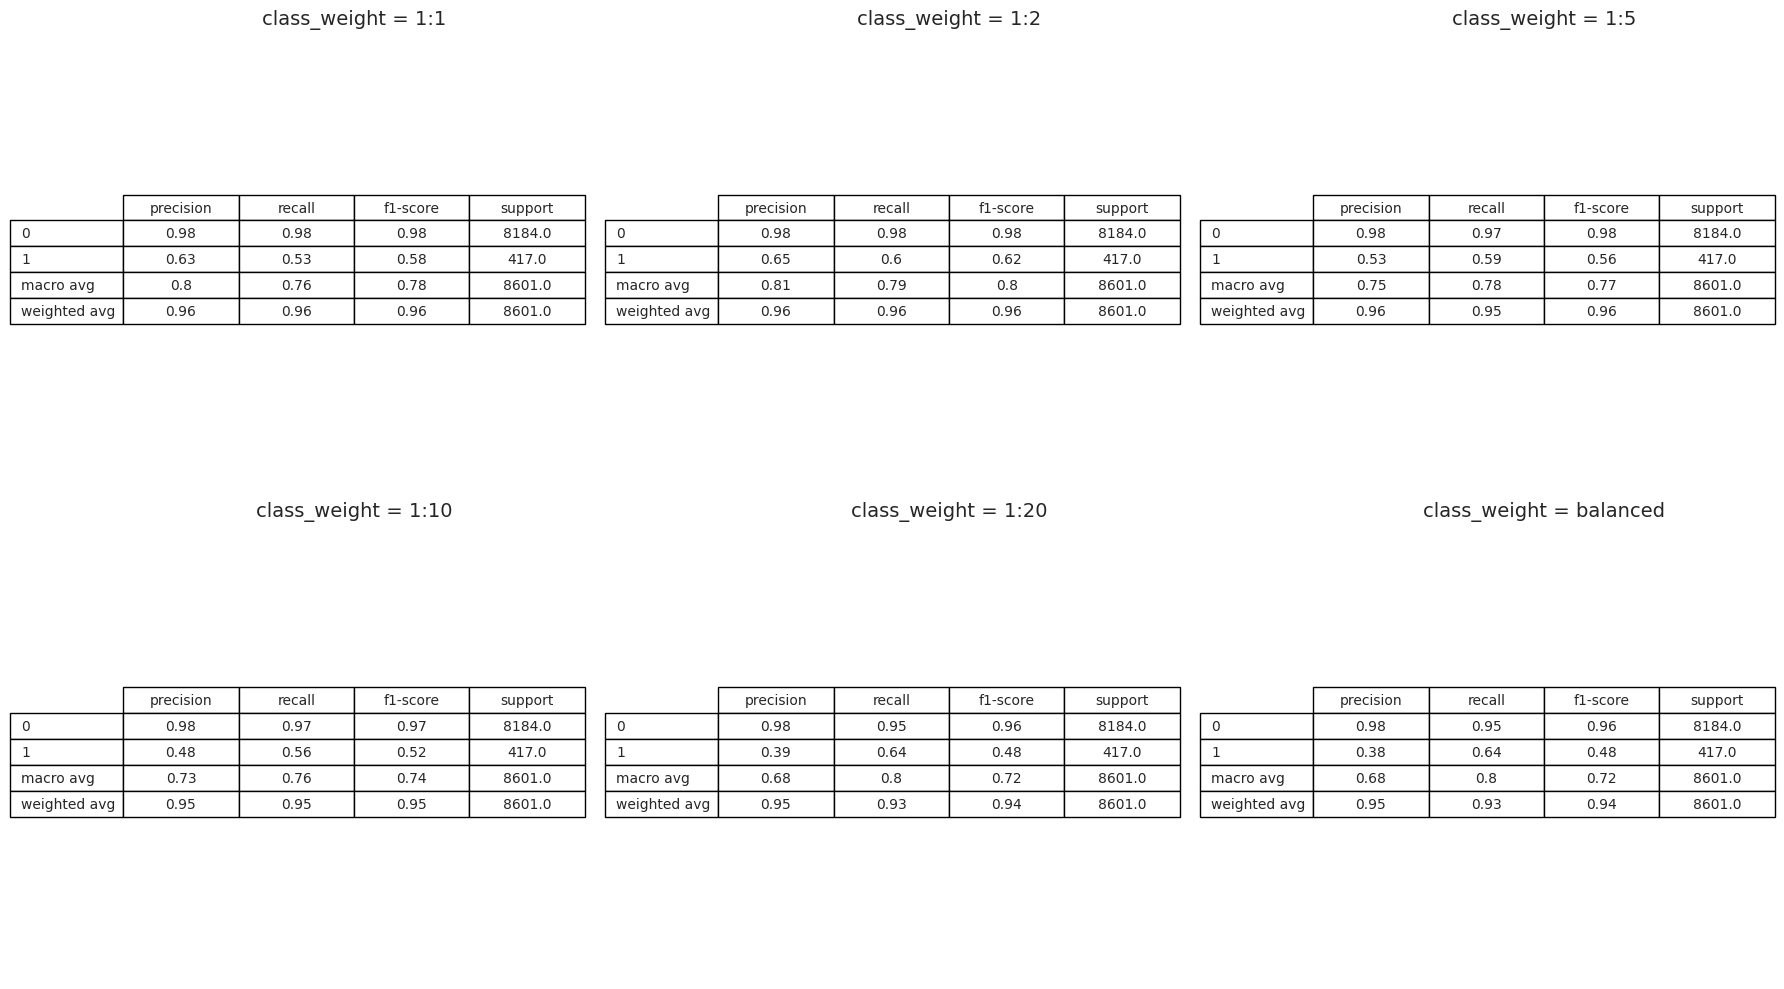

In [233]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (label, df) in enumerate(reports):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    ax.axis('off')
    ax.set_title(f"class_weight = {label}", fontsize=14)

    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()